20171103
Time evolution of matrix product mixed state. Using Trotter expansion to the second order

In [1]:
import numpy as np
from scipy import linalg
from tqdm import tqdm
import scipy
%matplotlib notebook
import matplotlib.pyplot as plt
import time
from scipy import io

Define basic functions

In [2]:
# returns Tr(o)
def mpotrace(o):
    L=len(o)
    temp=np.trace(o[0],axis1=0,axis2=1)
    for i in range(1,L):
        temp1=np.trace(o[i],axis1=0,axis2=1)
        temp=np.dot(temp,temp1)
    return temp[0,0]

# returns o*rho
def mpodot(o,rho):
    L=len(o)
    product=list()
    for i in range(0,L):
        temp=np.tensordot(o[i],rho[i],axes=([1,0])) # temp(os0,oa0,ob0,rhos0',rhoa0,rhob0)
        temp=np.transpose(temp,(0,3,1,4,2,5)) # temp(os0,rhos0',oa0,rhoa0,ob0,rhob0)
        sh=temp.shape
        temp=temp.reshape(sh[0],sh[1],sh[2]*sh[3],sh[4]*sh[5])
        product.append(temp)
    return product

# returns Tr(o*rho)
def exp(o,rho):
    L=len(rho)
    temp=np.tensordot(o[0],rho[0],axes=([0,1],[1,0])) # temp(oa0,ob0,rhoa0,rhob0) 
    temp=np.transpose(temp,(0,2,1,3)) # temp(oa0,rhoa0,ob0,rhob0)
    for i in range(1,L):
        temp=np.tensordot(temp,o[i],axes=(2,2)) # temp(oa0,rhoa0,rhob(i-1),osi,osi',obi)
        temp=np.tensordot(temp,rho[i],axes=([2,3,4],[2,1,0])) # temp(oa0,rhoa0,obi,rhobi)
    return (temp[0,0,0,0])

def uni(rho):
    L=len(rho)
    temp=rho[0]
    for i in range(1,L):
        temp=np.tensordot(temp,rho[i],axes=([len(np.shape(temp))-1,2]))
    return np.squeeze(temp)

# returns trace of rho^\dag*rho
def norm(rho):
    L=len(rho)
    temp=np.tensordot(np.conj(rho[0]),rho[0],axes=([0,1],[0,1])) # temp(a0',b0',a0,b0) 'belongs to conj.
    temp=np.transpose(temp,(0,2,1,3)) # temp(a0',a0,b0',b0)
    for i in range(1,L):
        temp1=np.tensordot(np.conj(rho[i]),rho[i],axes=([0,1],[0,1])) # temp1(ai',bi',ai,bi)
        temp=np.tensordot(temp,temp1,axes=([2,3],[0,2])) # temp(a0',a0,bi',bi)
    return abs(temp[0,0,0,0])

# two-site evolution
def evo2(A1,A2,U,chi):
    theta=np.tensordot(A1,A2,axes=([3,2])) # theta(si,si',ai,s(i+1),s(i+1)',b(i+1))
    dai=A1.shape[2] # dimension of ai
    dbip1=A2.shape[3] # dimension of b(i+1)
    # apply U, theta(si,ai,s(i+1),b(i+1),si',s(i+1)')
    theta=np.tensordot(theta,U,axes=([1,4],[0,1])) 
    # apply U^\dag, theta(si,s(i+1),ai,b(i+1),si',s(i+1)')
    theta=np.tensordot(np.conj(np.transpose(U,(2,3,0,1))),theta,axes=([2,3],[0,2])) 
    theta=np.transpose(theta,(0,4,2,1,5,3)) # theta(si,si',ai,s(i+1),s(i+1)',b(i+1))
    sh=theta.shape
    theta=theta.reshape(sh[0]*sh[1]*sh[2],sh[3]*sh[4]*sh[5])
    #print(theta)
    [L,S,R]=scipy.linalg.svd(theta, lapack_driver='gesvd')
    ent=S.shape[0];
    for i in range(1,S.shape[0]):
        if S[i]<thr*S[0]:
            ent=i
            break
    if ent<chi:
        D=np.diag(np.sqrt(S[0:ent]))
    else:
        ent=chi
        D=np.diag(np.sqrt(S[0:ent]))
    L=L[:,0:ent]#/np.trace(np.dot(np.transpose(L.conj()),L)) # L(si*ai,bi)
    R=R[0:ent,:]#/np.trace(np.dot(np.transpose(R.conj()),R)) # R(a(i+1),s(i+1)*b(i+1))
    R=np.dot(D,R)
    L=np.dot(L,D)
    B1=L.reshape(d,d,dai,ent)
    B2=np.transpose(R.reshape(ent,d,d,dbip1),(1,2,0,3))
    return B1,B2

# single-site evolution
def evo1(A,U):
    # A(si,si',ai,bi)
    # U(si,si')
    A=np.tensordot(A,U,axes=([1,0])) # A(si,ai,bi,si')
    A=np.tensordot(np.conj(np.transpose(U)),A,axes=([1,0])) # A(si,ai,bi,si')
    A=np.transpose(A,(0,3,1,2)) # A(si,si',ai,bi)
    return A

# returns otoc=-Tr([W,V]^2)=-(Tr(WVWV)-Tr(WWVV))
def otoc(W,V):
    o1=mpodot(W,V)
    o1=mpodot(o1,o1)
    o2=mpodot(W,W)
    o2=mpodot(o2,V)
    o2=mpodot(o2,V)
    return -(mpotrace(o1)-mpotrace(o2))

# normalize the density matrix by setting rho*rho^\dag=1
def normalize(rho):
    L=len(rho)
    Norm=norm(rho)
    for i in range(0,L):
        rho[i]=rho[i]*(1/Norm)**(0.5/N)

# evolve the density matrix according to gates U_int and U_single for Nsteps times 
def evo(rho,U_int,U_single,Nsteps,chi):
    L=len(rho)
    for p in range(0,Nsteps):
        for i in range(0,L-1,2):
        #for i in range(L-2,-1,-1):
            temp1,temp2=evo2(rho[i],rho[i+1],U_int,chi)
            rho[i]=temp1
            rho[i+1]=temp2
#         for i in range(0,L):
#             rho[i]=evo1(rho[i],U_single)

        #for i in range(L-2,-1,-1):
        for i in range(1,L-1,2):
            temp1,temp2=evo2(rho[i],rho[i+1],U_int,chi)
            rho[i]=temp1
            rho[i+1]=temp2
#         for i in range(1,L-1,2):
#             temp1,temp2=evo2(rho[i],rho[i+1],U_int,chi)
#             rho[i]=temp1
#             rho[i+1]=temp2
#         for i in range(0,L-1,2):
#         #for i in range(L-2,-1,-1):
#             temp1,temp2=evo2(rho[i],rho[i+1],U_int,chi)
#             rho[i]=temp1
#             rho[i+1]=temp2

        #normalize(rho)

def hcee(rho):
    L=len(rho)
    LA=int(L/2)
    R=np.trace(rho[LA],axis1=0,axis2=1)
    for i in range(LA,int(L)):
        temp=np.trace(rho[i],axis1=0,axis2=1)
        R=np.dot(R,temp)
    rhoA=list(rho[0:LA])
    rhoA[LA-1]=np.tensordot(rhoA[LA-1],R,axes=([3,0]))
    ta=tuple(range(0,2*LA,2))
    tb=tuple(range(1,2*LA,2))
    temp1=uni(rhoA)
    temp2=np.transpose(temp1,ta+tb)
    MA=temp2.reshape(2**LA,2**LA)
    lam=np.linalg.eigvalsh(MA)
    ee=0
    for i in range(0,np.size(lam)):
        if lam[i]<1e-5:
            break
        ee=ee-lam[i]*np.log(lam[i])
    return ee

def rotate(rhot,U):
    L=len(rhot)
    for i in range(0,L):
        rhot[i]=evo1(rhot[i],U)

Define initial state, Hamiltonian and observables

In [163]:
sx=np.array([[0.,1.],[1.,0.]])
sy=np.array([[0.,-1j],[1j,0.]])
sz=np.array([[1.,0.],[0.,-1.]])

d=2 # Dimension. For spin 1/2 the dimention = 2
J=1. # interaction coefficient
gx=0. # X field strength
gy=0. # Y field strength
gz=0. # Z field strength
interaction='Dipolar' # Heisenberg: J(XX+YY+ZZ); Ising: JXX; Dipolar J(XX-(YY+ZZ)/2)
N=12 # Total number of spins
delta =0.4 # Time step
chi0=40 # Maximum number of singular values at t=0
Vc=5*J # upper bound of the growth velocity of correlation length. chi=max(chi0,Vc*t)
thr=0; # discarding singular values smaller than thr*largest singular value
T=40 # evolution time to be simulated
rho0i=sz # initial spin polarization

Nsteps=1 # number of evolution steps between two measurements

if interaction=='Heisenberg':
    h_int=J*np.kron(sx,sx)+J*np.kron(sy,sy)+J*np.kron(sz,sz)
elif interaction=='Ising':
    h_int=J*np.kron(sx,sx)
elif interaction=='Dipolar':
    h_int=J*(np.kron(sx,sx)-np.kron(sz,sz)/2-np.kron(sy,sy)/2)
else:
    raise NameError('Invalid interaction')

h_single=gz*sz+gx*sx+gy*sy
U_int=linalg.expm(1j*h_int*delta).reshape(d,d,d,d) # U(si,s(i+1),si',s(i+1)')
U_single=linalg.expm(1j*h_single*delta).reshape(d,d) # U(si,si')

Mz=list()
Mz.append(np.transpose(np.array([[sz,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[sz,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    Mz.append(temp)
Mz.append(np.transpose(np.array([[np.eye(2)],[sz]]),(2,3,0,1))) # Mz(i,si,si',ai,bi)

Mx=list()
Mx.append(np.transpose(np.array([[sx,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[sx,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    Mx.append(temp)
Mx.append(np.transpose(np.array([[np.eye(2)],[sx]]),(2,3,0,1))) # Mz(i,si,si',ai,bi)

V0=Mz # OTOC=-Tr[rhot,V0]^2

rho0=list()
rho0.append(np.transpose(np.array([[rho0i,np.eye(2)]]),(2,3,0,1)))
for i in range(1,N-1):
    temp1=np.array([[np.eye(2),np.zeros((2,2))],[rho0i,np.eye(2)]])
    temp=np.transpose(temp1,(2,3,0,1))
    rho0.append(temp)
rho0.append(np.transpose(np.array([[np.eye(2)],[rho0i]]),(2,3,0,1))) # rho(i,si,si',ai,bi)

# beta=0.001
# rho0i=linalg.expm(-beta*sz).reshape(d,d,1,1) # rho0i(si,si',ai,bi)
# rho0=list()
# for i in range(0,N):
#     rho0.append(rho0i)

In [164]:
start=time.time()
Npts=int(T/delta/Nsteps+1) # number of points to evalue the observables
tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)

MzExp=np.zeros(Npts)
MxExp=np.zeros(Npts)

# rho=list(Mx)
rho=list(rho0)
normalize(rho)
MzExp[0]=np.real(exp(Mz,rho))
MxExp[0]=np.real(exp(Mx,rho))

for p in tqdm(range(1,Npts)):
    evo(rho,U_int,U_single,Nsteps,chi0)
    MzExp[p]=np.real(exp(Mz,rho))
    MxExp[p]=np.real(exp(Mx,rho))
    #print(tlist[p])
end=time.time()
print(end-start)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.13it/s]


0.8121330738067627


In [ ]:
Tcon=5
Npts=int(Tcon/delta/Nsteps) # number of points to evalue the observables
tlist=np.append(tlist,np.arange(tlist[-1]+delta*Nsteps,Npts*delta*Nsteps,delta*Nsteps))

MzExp=np.zeros(Npts)
MxExp=np.zeros(Npts)

# rho=list(Mx)
rho=list(rho0)
normalize(rho)
MzExp[0]=np.real(exp(Mz,rho))
MxExp[0]=np.real(exp(Mx,rho))

for p in range(1,Npts):
    evo(rho,U_int,U_single,Nsteps,chi)
    MzExp[p]=np.real(exp(Mz,rho))
    MxExp[p]=np.real(exp(Mx,rho))

In [43]:
plt.plot(np.arange(0,40.,2*delta),MxExp1[0:200:2]/MxExp1[0])
plt.show()

C:\Users\Pai\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [63]:
plt.plot(tlist[0:101],(MzExp/MzExp[0]-MxExp1[0:201:2]/MxExp1[0])**2)
plt.show()

C:\Users\Pai\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


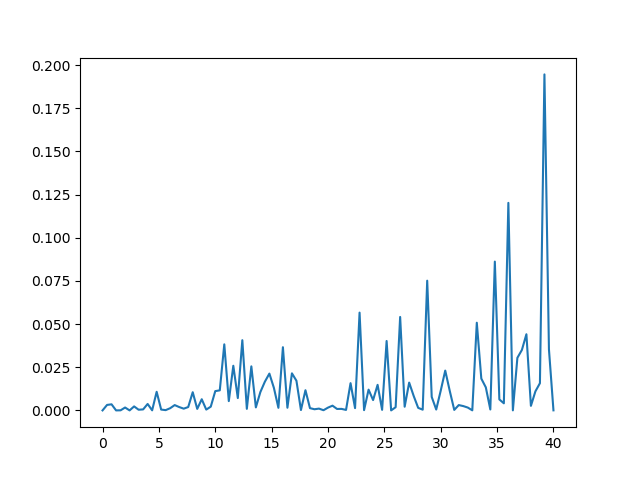

C:\Users\Pai\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [166]:
plt.figure(1)
plt.plot(tlist[0:101],(MzExp/MzExp[0]-MxExp1[0:4001:40]/MxExp1[0])**2)
plt.show()

In [167]:
error1=np.append(error1,np.mean(abs(MzExp/MzExp[0]-MxExp1[0:4001:40]/MxExp1[0])))
delta_l1=np.append(delta_l1,delta)

In [162]:
error1

array([  3.91741526e-04,   9.79527360e-05,   1.56586413e-03,
         3.67184645e-02])

In [168]:
plt.figure(2)

plt.loglog(np.sort(delta_l1),np.sort(error1))
plt.show()

<IPython.core.display.Javascript object>


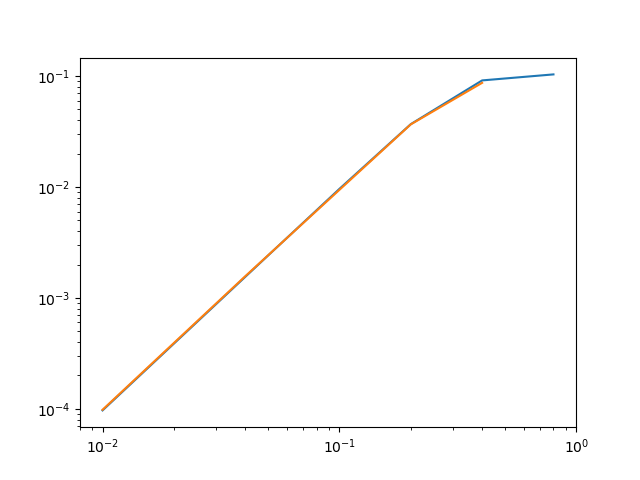

In [111]:
plt.figure(2)

plt.loglog(np.sort(delta_list),np.sort(error))
plt.show()

In [141]:
error1=np.mean(abs(MzExp/MzExp[0]-MxExp1[0:4001:2]/MxExp1[0]))
delta_l1=delta

In [28]:
Mx1=MxExp

In [99]:
dictpp=io.loadmat('M_z_6')

MxExp1=dictpp['M_z']

MxExp1=np.squeeze(MxExp1)

MxExp1.shape

(5000,)

In [ ]:
start=time.time()
Npts=int(T/delta/Nsteps+1) # number of points to evalue the observables
tlist=np.arange(0,Npts*delta*Nsteps,delta*Nsteps)
gzlist=np.arange(0.6,1.5,0.1)
OTOC=np.zeros((len(tlist),len(gzlist)))

for pp in range(0,len(gzlist)):
    gz=gzlist[pp]
    h_single=gz*sz
    U_single=linalg.expm(1j*h_single*delta).reshape(d,d) # U(si,si')
    rho=list(rho0)
    normalize(rho)
    OTOC[0,pp]=np.real(otoc(rho,V0))
    for p in range(1,Npts):
        evo(rho,U_int,U_single,Nsteps,chi0)
        OTOC[p,pp]=np.real(otoc(rho,V0))
    print(gz)
end=time.time()
print(end-start)

In [157]:
start=time.time()
T=5
Npts=round(T/delta) # number of points to evalue the observables
q_max=11
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]

rho0=Mz
rho=list(rho0)
v0=sz # encoding axis
normalize(rho)
for p in range(0,5):
    evo(rho,U_int,U_single,int(Npts/5),chi0)
    print(p)
for phi in phi_list:
    U_phi=linalg.expm(1j*phi/2*v0)
    rhot=list(rho)
    rotate(rhot,U_phi)
    s_list=np.append(s_list,np.real(exp(rhot,rho)))
    print(phi)
q_list=np.fft.rfft(s_list)/q_max
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),abs(q_list)))
end=time.time()
print(end-start)

0
1
2
3
4
0.0
0.285599332145
0.571198664289
0.856797996434
1.14239732858
1.42799666072
1.71359599287
1.99919532501
2.28479465716
2.5703939893
2.85599332145
3.14159265359
3.42719198573
3.71279131788
3.99839065002
4.28398998217
4.56958931431
4.85518864646
5.1407879786
5.42638731075
5.71198664289
5.99758597504
1480.4866073131561


In [144]:
q_max=15
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]
for phi in phi_list:
    U_phi=linalg.expm(1j*phi/2*v0)
    rhot=list(rho)
    rotate(rhot,U_phi)
    s_list=np.append(s_list,np.real(exp(rhot,rho)))
    print(phi)
q_list=np.fft.rfft(s_list)/q_max
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),abs(q_list)))

0.0
0.209439510239
0.418879020479
0.628318530718
0.837758040957
1.0471975512
1.25663706144
1.46607657168
1.67551608191
1.88495559215
2.09439510239
2.30383461263
2.51327412287
2.72271363311
2.93215314335
3.14159265359
3.35103216383
3.56047167407
3.76991118431
3.97935069455
4.18879020479
4.39822971503
4.60766922527
4.8171087355
5.02654824574
5.23598775598
5.44542726622
5.65486677646
5.8643062867
6.07374579694


SyntaxError: invalid syntax (<ipython-input-57-736efb77e981>, line 1)

In [158]:
otoc

4.478604188666206

In [154]:
otoc

4.6315402188232673

In [115]:
Npts

250

In [373]:
rho[2].shape

(2, 2, 16, 64)

In [142]:
q_list

array([  7.79223207e-01 +0.00000000e+00j,
        -1.66230287e-03 +4.42549529e-17j,
         4.77055131e-01 -9.50252248e-16j,
        -6.01600134e-04 +4.14109046e-17j,
         1.14549630e-01 -1.33901002e-15j,
        -1.14089785e-04 +4.11537976e-16j,
         1.50746777e-02 +6.94900197e-16j,
        -1.26542485e-05 -8.76389558e-16j,
         1.23582390e-03 +6.97738998e-16j,
        -8.11344236e-07 -4.62758874e-16j,
         5.98994881e-05 +3.08367019e-16j,  -5.42278997e-08 +0.00000000e+00j])

In [100]:
rhot=list(rho)
U_phi=linalg.expm(1j*0*v0)
rotate(rhot,U_phi)
exp(rhot,rho)

0.036338323316647422

In [129]:
exp(rho,rho)

0.99999999999999756

In [127]:
mpotrace(mpodot(rho,rho))

(0.99999999999999201+4.3557614876066353e-09j)

In [118]:
s_list

array([ 0.0628112 ,  0.05007766,  0.04648016,  0.05908808,  0.07105895,
        0.07165611,  0.06937655,  0.0628112 ,  0.05007766,  0.04648016,
        0.05908808,  0.07105895,  0.07165611,  0.06937655])

In [ ]:
import multiprocessing as mp
def overlap(rho,phi):
    U_phi=linalg.expm(1j*phi/2*v0)
    rhot=list(rho)
    evo(rhot,np.eye(d**2).reshape(d,d,d,d),U_phi,1,chi0)
    return mpotrace(mpodot(rhot,rho))

start=time.time()
T=5
Npts=round(T/delta) # number of points to evalue the observables
q_max=10
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]

rho0=Mx
rho=list(rho0)
v0=sz # encoding axis
normalize(rho)
evo(rho,U_int,U_single,Npts,chi0)
pool=mp.Pool(processes=6)
results = [pool.apply_async(overlap, args=(rho,x)) for x in phi_list]
s_list = [p.get() for p in results]


q_list=np.fft.rfft(s_list)#/q_max
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),abs(q_list)))
end=time.time()
print(end-start)

In [107]:
norm(rho)

MemoryError: 

In [39]:
# plt.close()
plt.figure(1)
for p in range(0,len(tlist)):
    plt.plot(gzlist,OTOC[p,:])
plt.show()

<IPython.core.display.Javascript object>


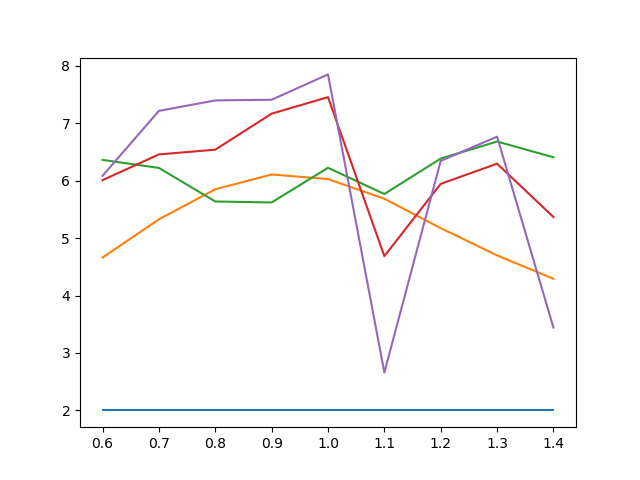

In [9]:
# plt.close()
plt.figure(1)
for p in range(0,len(tlist)):
    plt.plot(gzlist,OTOC[p,:])
plt.show()

In [15]:
np.multiply(np.array([1,2]),np.array([[3],[4]]))

array([[3, 6],
       [4, 8]])

In [239]:
import pip
pip.main(['install','tqdm'])
from tqdm import tqdm

In [57]:
np.fft.rfft([1,1,1,1,1])

array([ 5.+0.j,  0.+0.j,  0.+0.j])

In [55]:
Npts

101

In [22]:
start=time.time()
T=2
Npts=round(T/delta) # number of points to evalue the observables
q_max=10
phi_list=np.arange(0,2*q_max,1)*2*np.pi/(2*q_max)
s_list=[]

rho0=Mx
rho=list(rho0)
v0=sz # encoding axis
normalize(rho)
evo(rho,U_int,U_single,Npts,chi0)
for phi in phi_list:
    U_phi=linalg.expm(1j*phi/2*v0)
    rhot=list(rho)
    evo(rhot,np.eye(d**2).reshape(d,d,d,d),U_phi,1,chi0)
    evo(rhot,np.conj(U_int),np.conj(U_single),Npts,chi0)
    s_list=np.append(s_list,np.real(exp(rhot,rho0)))
    print(phi)
q_list=np.fft.rfft(s_list)#/len(s_list)
otoc=sum(np.multiply(np.power(np.arange(0,len(q_list)),2),abs(q_list)))
end=time.time()
print(end-start)

KeyboardInterrupt: 

In [1]:
import sys
sys.version

'3.6.3 |Anaconda, Inc.| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]'